# Load Dataset

In [7]:
# ---------------------------------------------
# Step 1: Load Dataset from HUB
# ----------------------------------------------
from datasets import load_dataset

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

dataset = load_dataset("tomascanivari/buildings-extraction-coco-hf")
dataset

DatasetDict({
    train: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 3784
    })
    val: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 933
    })
    test: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 1000
    })
})

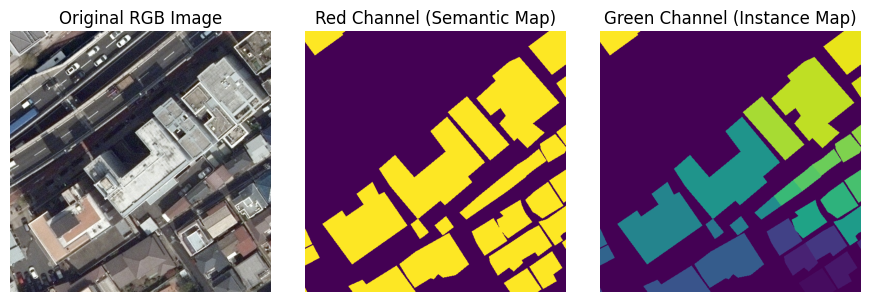

Classes:  [0 1]
Instances:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [8]:
# Quick test
import numpy as np
import matplotlib.pyplot as plt

idx = 0

training_example = dataset["train"][idx]

# Convert PIL images to numpy arrays
original_img = np.array(training_example["PIL_image"], dtype=np.uint8)
annotation_img = np.array(training_example["PIL_annotation"], dtype=np.uint8)

# Extract channels
red_channel = annotation_img[..., 0]   # semantic map stored in red
green_channel = annotation_img[..., 1] # instance map in green

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(original_img)
axes[0].set_title("Original RGB Image")
axes[0].axis("off")

axes[1].imshow(red_channel)
axes[1].set_title("Red Channel (Semantic Map)")
axes[1].axis("off")

axes[2].imshow(green_channel)
axes[2].set_title("Green Channel (Instance Map)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("Classes: ", np.unique(red_channel))
print("Instances: ", np.unique(green_channel))

In [9]:
# ----------------------------------------------------------------------------------------
# Step 2: Convert HF Dataset into PyTorch DataLoader
# ----------------------------------------------------------------------------------------
import torch

import numpy as np
import albumentations as A

from torch.utils.data import Dataset # To make ImageSegmentationDataset a PyTorch dataset 
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation

class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset,  processor, transform=None):
        # Initialize the dataset, local_path and transform variables
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        # Return the number of datapoints
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get image information
        img_info = self.dataset[idx]["image_info"]
        img_height, img_width = img_info["height"], img_info["width"]
        
        # Get the PIL image
        image = np.array(self.dataset[idx]["PIL_image"].convert("RGB"), dtype=np.uint8)

        # Get the PIL annotation
        annotation = np.array(self.dataset[idx]["PIL_annotation"], dtype=np.uint8)

        # Get Semantic Map (Red channel) & Instance Map (Green chanel)
        semantic_map = annotation[:,:,0]
        instance_map = annotation[:,:,1]
        
        # Get class labels
        class_labels = np.unique(semantic_map)          # In this case 1 -> 'building'

        # Get instance -> class mapping
        instance_to_class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_map[semantic_map == label])
            instance_to_class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_map)
            image, instance_map = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
            inputs = self.processor(
                [image], 
                [instance_map], 
                instance_id_to_semantic_id=instance_to_class, 
                return_tensors="pt"
            )
            inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

# Define the configurations of the transforms specific
# to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
# Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

processor = Mask2FormerImageProcessor(do_reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

# Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    dataset=dataset["train"],
    processor=processor,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    dataset=dataset["val"],
    processor=processor,
    transform=train_val_transform
)

In [10]:
# Quick Test
example = train_dataset[0]

for k,v in example.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape, v.dtype)
  else:
    print(k,[x.shape for x in v])

print("Unique Labels: ", np.unique(example['mask_labels']))

print(example['class_labels'])

pixel_values torch.Size([3, 512, 512]) torch.float32
pixel_mask torch.Size([512, 512]) torch.int64
mask_labels torch.Size([31, 512, 512]) torch.float32
class_labels torch.Size([31]) torch.int64
Unique Labels:  [0. 1.]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [5]:
# Check if all mask labels instances have a corresponding class label
# from tqdm import tqdm

# for idx in tqdm(range(len(train_dataset))):
#     example = train_dataset[idx]
#     if example["mask_labels"].shape[0] != example["class_labels"].shape[0]:
#         print("Different", example["mask_labels"].shape,  example["class_labels"].shape)

# for idx in tqdm(range(len(val_dataset))):
#     example = val_dataset[idx]
#     if example["mask_labels"].shape[0] != example["class_labels"].shape[0]:
#         print("Different", example["mask_labels"].shape,  example["class_labels"].shape)

Label: building


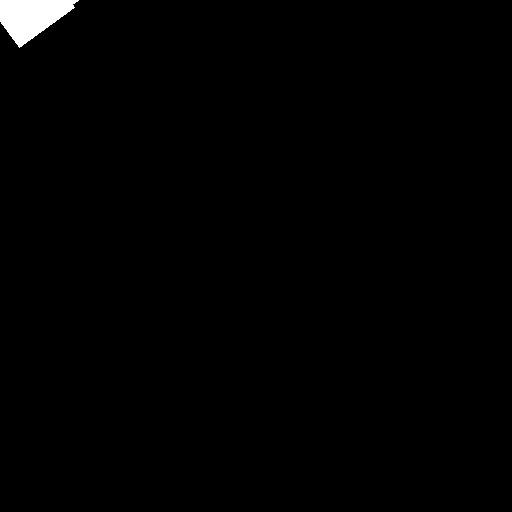

In [11]:
from PIL import Image

idx = 30

# visualize first one
print("Label:", id2label[example["class_labels"][idx].item()])

visual_mask = (example["mask_labels"][idx].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

In [12]:
# ----------------------------------------------------------------------------------------
# Step 3: Create PyTorch DataLoader
# ----------------------------------------------------------------------------------------

# Even though it is not used in Trainer, it helps to verify the collate_fn

from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {
        "pixel_values": pixel_values, 
        "pixel_mask": pixel_mask, 
        "class_labels": class_labels,
        "mask_labels": mask_labels
    }

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [13]:
# Quick Check on Batch
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2


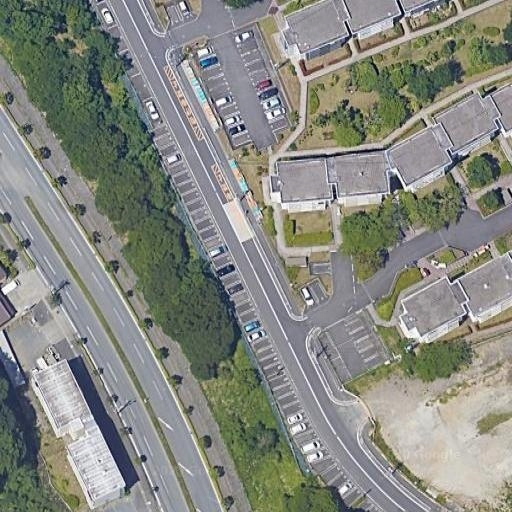

In [14]:
# Quick Check on Inputs

from PIL import Image

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

batch_index = 0

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

(3, 512, 512)


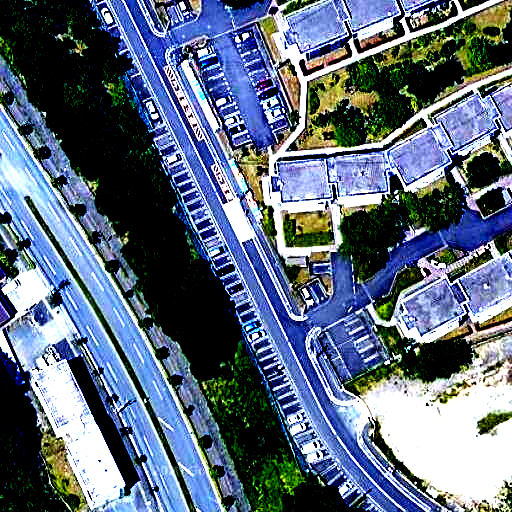

In [15]:
image = batch["pixel_values"][batch_index].numpy()

print(image.shape)
image = np.moveaxis(image, 0, 2)
image = (image * 255).clip(0, 255).astype(np.uint8)  # convert float32→uint8
Image.fromarray(image)

In [16]:
batch["class_labels"][batch_index], id2label[0]

(tensor([0, 0, 0, 0, 0, 0]), 'building')

In [17]:
batch["mask_labels"][batch_index].shape, batch["class_labels"][batch_index].shape

(torch.Size([6, 512, 512]), torch.Size([6]))

Visualizing mask for: building


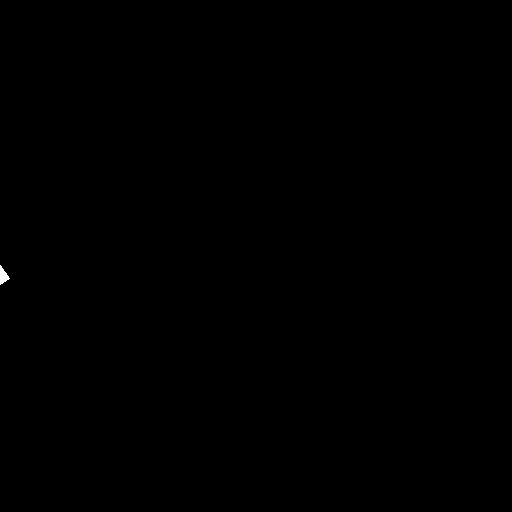

In [18]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

In [19]:
# ----------------------------------------------------------------------------------------
# Step 4: Load the Mask2Former Model
# ----------------------------------------------------------------------------------------

import torch
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# checkpoint = "facebook/mask2former-swin-tiny-coco-instance"
# checkpoint = "facebook/mask2former-swin-base-coco-instance"
checkpoint = "facebook/mask2former-swin-large-coco-instance"
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint,
    id2label=id2label,
    ignore_mismatched_sizes=True,
).to(device)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Quick check
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
[torch.Size([40]), torch.Size([12])]
[torch.Size([40, 512, 512]), torch.Size([12, 512, 512])]


In [ ]:
# # Compute initial loss to check
# pixel_values = batch["pixel_values"].to(device)

# # Move each element in the lists to GPU
# mask_labels = [m.to(device) for m in batch["mask_labels"]]
# class_labels = [c.to(device) for c in batch["class_labels"]]

# outputs = model(
#           pixel_values=pixel_values,
#           mask_labels=mask_labels,
#           class_labels=class_labels,
#       )
# outputs.loss

In [21]:
# ----------------------------------------------------------------------------------------
# Step 5: Define training arguments and trainer 
# ----------------------------------------------------------------------------------------
from transformers import TrainingArguments, Trainer

torch.cuda.empty_cache()

epochs = 15
lr = 3e-5                      # safer for small batch & limited data
batch_size = 1
grad_accum = 8                 # simulate effective batch of 8 if possible

training_args = TrainingArguments(
    output_dir=f"train/mask2former-swin-large-coco-instance-finetuned-buildings",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_accum,
    num_train_epochs=epochs,
    lr_scheduler_type="cosine",  # smoother LR decay
    warmup_ratio=0.05,           # small warmup (~5% of steps)
    weight_decay=0.01,           # light regularization
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_steps=10,
    save_total_limit=2,          # keep disk lighter
    load_best_model_at_end=True,
    fp16=True,                   # crucial for 6GB GPU
    dataloader_num_workers=1,    # avoid CPU bottleneck
    report_to=[],                # keep logs local
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train
trainer.train()

Minimum Training Loss: 11.0123 at Epoch 13
Minimum Validation Loss: 13.3487 at Epoch 12


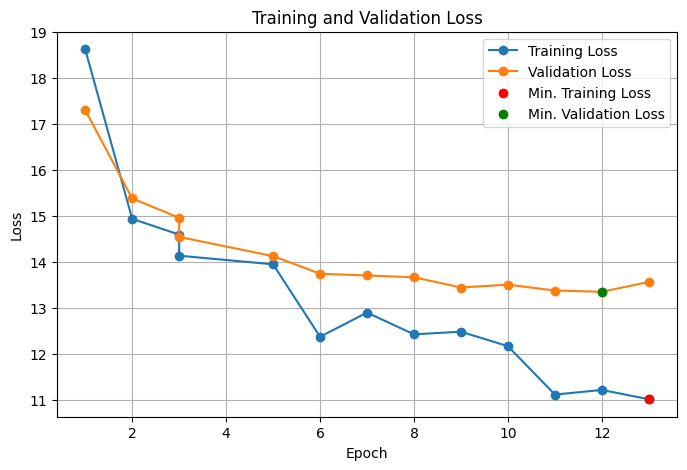

In [22]:
import matplotlib.pyplot as plt

# Epoch, Training Loss, Validation Loss
loss = [
    (1, 18.625100, 17.303162),
    (2, 14.935600, 15.379188),
    (3, 14.593100, 14.959031),
    (3, 14.134300, 14.542134),
    (5, 13.946700, 14.125193),
    (6, 12.370600, 13.741511),
    (7, 12.897000, 13.703479),
    (8, 12.423700, 13.664842),
    (9, 12.480800, 13.442265),
    (10, 12.165400, 13.504070),
    (11, 11.113800, 13.376662),
    (12, 11.213700, 13.348657),
    (13, 11.012300, 13.563123),
]

# Convert to separate lists for plotting
epochs = [x[0] for x in loss]
train_loss = [x[1] for x in loss]
val_loss = [x[2] for x in loss]

# Find minimum training loss
min_train = min(loss, key=lambda x: x[1])
print(f"Minimum Training Loss: {min_train[1]:.4f} at Epoch {min_train[0]}")

# Find minimum validation loss
min_val = min(loss, key=lambda x: x[2])
print(f"Minimum Validation Loss: {min_val[2]:.4f} at Epoch {min_val[0]}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')

# Highlight minima
plt.scatter(min_train[0], min_train[1], color='red', zorder=5, label='Min. Training Loss')
plt.scatter(min_val[0], min_val[2], color='green', zorder=5, label='Min. Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()

# Save plot
plt.savefig('train/mask2former-swin-large-coco-instance-finetuned-buildings/checkpoint-5676/loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()